LIBRARIES

In [3]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns

DEFAULTS

In [4]:
# Define path to files
# For MacOS
# PATH = "/Users/derekbanas/Documents/Tutorials/Python for Finance/Stocks/"
# For Windows
PATH = "C:/Users/yeerd/OneDrive/Masaüstü/stock_data/Stock_List/"

# Start date defaults
S_YEAR = 2017
S_MONTH = 1
S_DAY = 3
S_DATE_STR = "2017-01-03"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

# End date defaults
E_YEAR = 2021
E_MONTH = 8
E_DAY = 19
E_DATE_STR = "2021-08-19"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)

DF FROM CSV

In [5]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

REGRESSION ANALYSIS

<AxesSubplot:xlabel='eval', ylabel='beauty'>

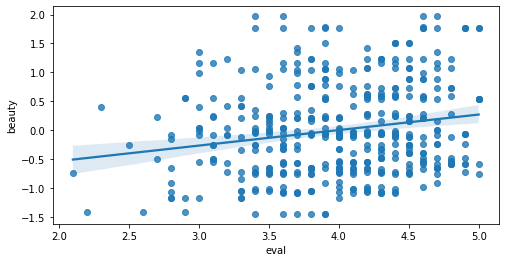

In [6]:
# This is a dataset that evaluates beauty & teacher evaluations
beauty = sm.datasets.get_rdataset("TeachingRatings", "AER")

# We are plotting a scatter plot with a regression line that
# estimates the mean of the results.
plt.figure(figsize=(8,4))
sns.regplot(x="eval", y="beauty", data=beauty.data)

# This data is rather inconclusive

ANOTHER EXAMPLE REGRESSION LINE

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

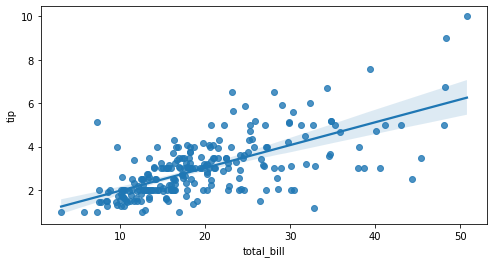

In [7]:
# This time will we analyze whether the total bill effects
# the tip people leave at restaurants
# Load tip dataset
tips = sns.load_dataset("tips")
# Get column data in dataset
tips.columns

y = tips['total_bill']
x1 = tips['tip']

# Define the intercept to the y line
x = sm.add_constant(x1)

# OLS Ordinary Least Squares : Estimates the data so a line can 
# be drawn through data points
results = sm.OLS(y,x).fit()
results.summary()

plt.figure(figsize=(8,4))
sns.regplot(x="total_bill", y="tip", data=tips)

# Here it is clear that are guess that bill amounts effect tips
# seems to be true

ARIMA

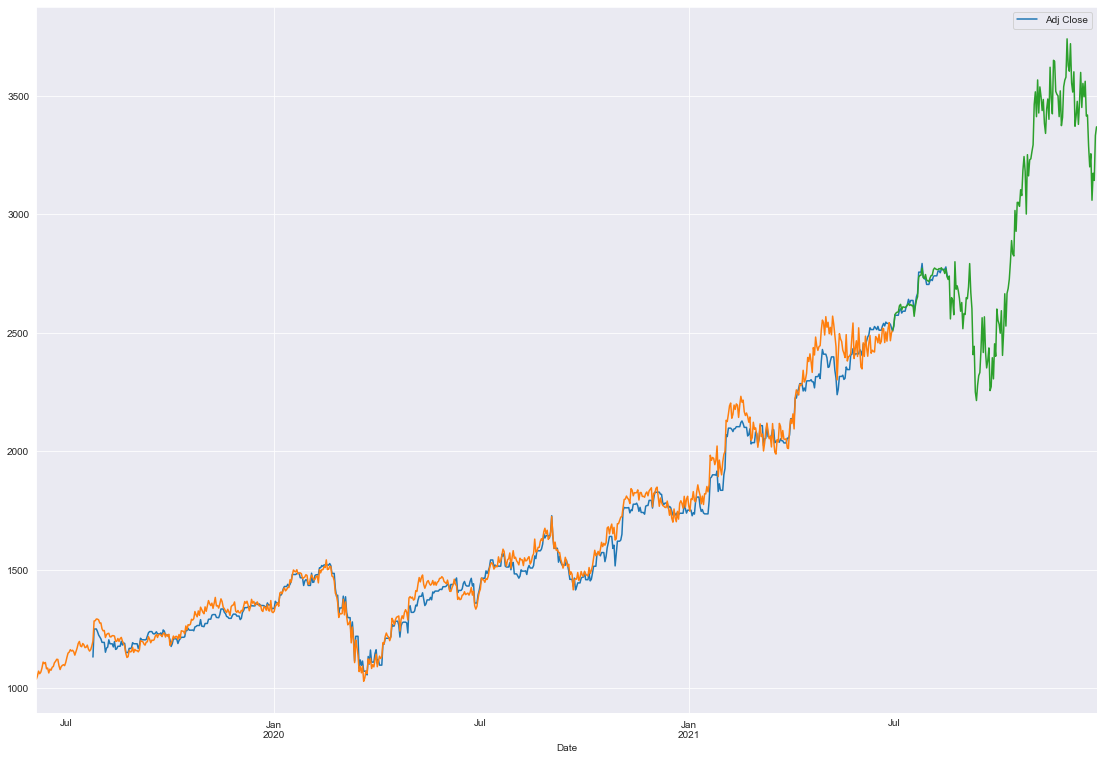

In [29]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

a_df = get_df_from_csv("GOOG") 

a_df = a_df.asfreq('d') # Change frequency to day
a_df.index # Check frequency
a_df = a_df.fillna(method='ffill') # Fill missing values

# Delete unnamed column
a_df.drop(a_df.columns[a_df.columns.str.contains('unnamed',case = False)],
          axis = 1, inplace = True)

# Delete daily return column
a_df = a_df.drop(['daily_return'], axis=1)

a_df

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()
# ax = a_df.plot(ax=ax)

# Figure out optimum lags which will be 1 or 2 for this data set
lags = ar_select_order(a_df, maxlag=30)

# Create our model using whole data set
model = AutoReg(a_df['Adj Close'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
len(a_df) # 1166 observations
train_df = a_df.iloc[50:933] # 80% minus 1st 50
test_df = a_df.iloc[933:] # Last 20%

# Define training model for 500 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(a_df['Adj Close'], 800).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 100 days into the future
forecast = train_model.predict(start=end, end=end+180, dynamic=True)
ax = forecast.plot(ax=ax) # Green